In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cartopy.crs as ccrs

In [3]:
import torch
import torch.nn
import torch.nn.functional as F

In [4]:
import scipy.ndimage.filters

In [5]:
import scipy.signal

In [6]:
import PIL.Image

In [272]:
def make_image(x):
    scaled = (np.nan_to_num(x).clip(200,305)-200)/(305-200)*255
    return PIL.Image.fromarray(255 - scaled.astype(np.uint8))

In [8]:
def resize(im, size=(512,512)):
    return im.resize(size, resample=PIL.Image.NEAREST)

In [9]:
from tqdm import tqdm

In [10]:
%cd ..

/ships19/cloud/scratch/cphillips/isccp_l1g


In [11]:
import sys 
sys.path.append('/ships19/cloud/scratch/cphillips/utility')
from make_gif import make_video, render_fast, play_video

In [12]:
import xarray as xr

In [13]:
from pathlib import Path

In [14]:
import make_sample

(3, 3600, 7200)


In [227]:
ds = xr.open_dataset('/ships19/cloud/scratch/himawari08/2020/301/level2/clavrx_H08_20201027_0000_B01_FLDK_R.level2.nc')
ds = ds.rename(pixel_elements_along_scan_direction='x',scan_lines_along_track_direction='y')
ds = ds.sel(y=slice(2000,2128),x=slice(2000,2128))

In [284]:
emis_temp = ds.cld_temp_acha.values.copy()
mask = np.isnan(emis_temp)
emis_temp[mask] = ds.surface_temperature_retrieved.values[mask]

In [285]:
emis = ds.cld_emiss_acha.values

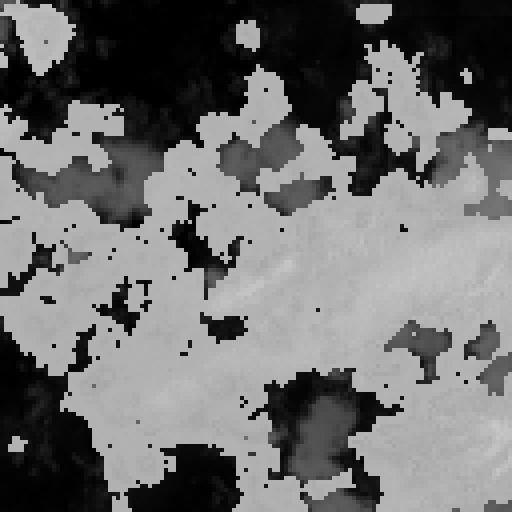

In [286]:
resize(make_image(emis_temp))

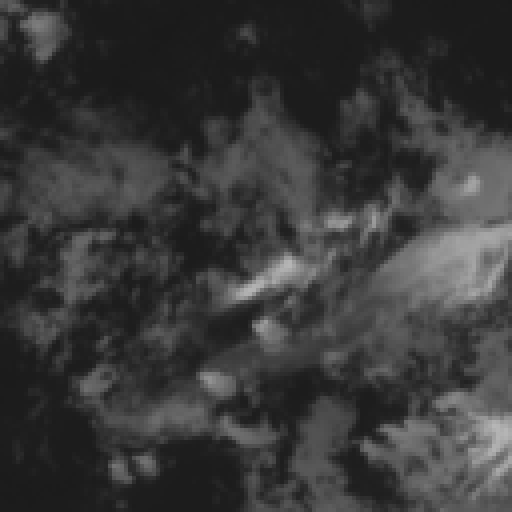

In [287]:
resize(make_image(ds.temp_10_4um_nom.values))

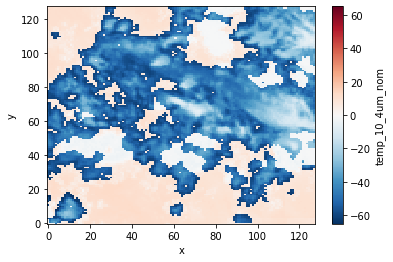

In [275]:
(emis_temp-ds.temp_10_4um_nom).plot()

Text(0, 0.5, 'ACHA Emission Temperature')

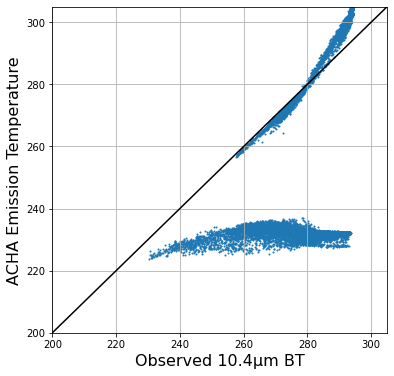

In [268]:
figure(figsize=(6,6))
scatter(ds.temp_10_4um_nom.values, emis_temp, s=1)
plot([200,305],[200,305], color='k')
grid()
xlim([200,305])
ylim([200,305])
xlabel('Observed 10.4µm BT',fontsize=16)
ylabel('ACHA Emission Temperature',fontsize=16)

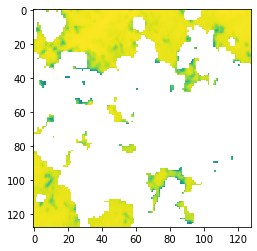

In [256]:
imshow((ds.temp_10_4um_nom.where((emis_temp - ds.temp_10_4um_nom.values) > 0)))

* Assume there exists an old high resolution clavrx file already
* Each low-res 10.3 corresponds to the weighted sum of 10.3 in high-resolution
* In some neighborhood in the high-res, there are multiple values of emis temp that could average to the low-res pixel

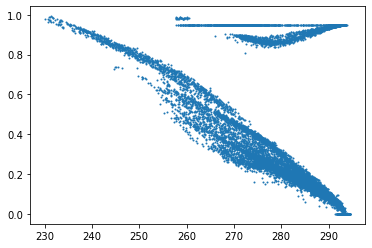

In [234]:
scatter(ds.temp_10_4um_nom.values, emis, s=1)
#plot([180,300],[180,300], color='k')

In [15]:
AHI_PROJ = ccrs.Geostationary(140.7)

In [16]:
files = list(Path('l1b/2020/202007/20200701/20200701T0000/h8/temp_10_40um/').glob('*'))

In [17]:
scene, area = make_sample.read_scene(files, None)

In [18]:
search = scene[2000:2512,2000:2512].load().values

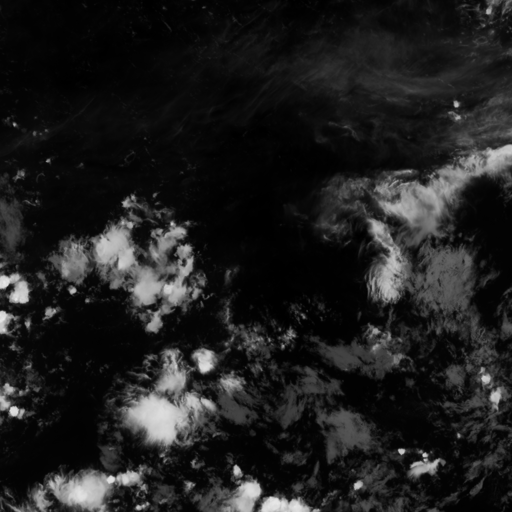

In [19]:
resize(make_image(search))

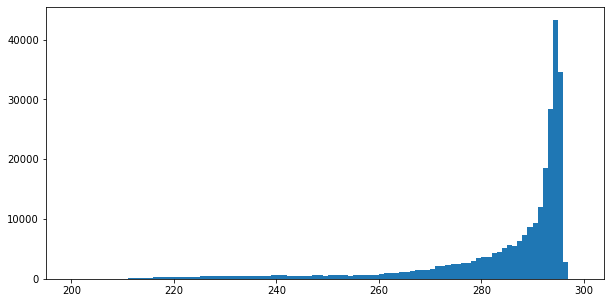

In [26]:
bins = np.arange(200,300)
figure(figsize=(10,5))
hist(search.ravel(), bins=bins);

In [184]:
resample = (search**4).reshape((32,16,32,16)).mean(axis=(1,3))**.25

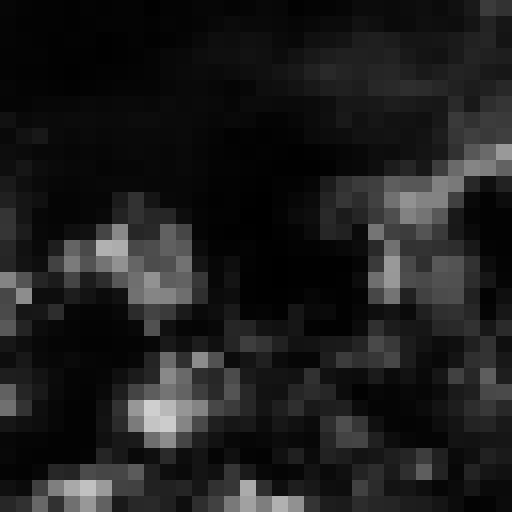

In [185]:
resize(make_image(resample))

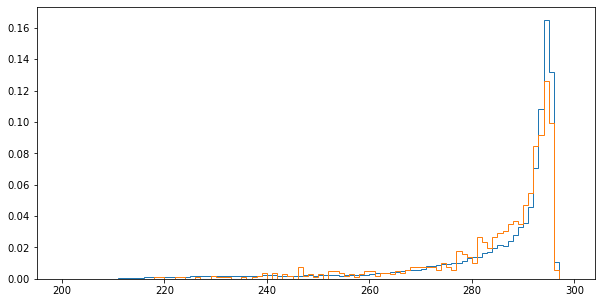

In [187]:
bins = np.arange(200,300)
figure(figsize=(10,5))
hist(search.ravel(), bins=bins, density=True, histtype='step');
hist(resample.ravel(), bins=bins, density=True, histtype='step');
#yscale('log')

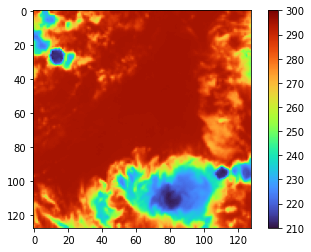

In [182]:
imshow(search[-128:,:128], vmin=210, vmax=300, cmap='turbo')
colorbar()

In [66]:
import netCDF4

In [131]:
ds = xr.open_dataset('/tmp/gfs.20200630.t12z.pgrb2f12',
                engine='cfgrib',
                     backend_kwargs=dict(filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
                    )

skipping variable: paramId==157 shortName='r'
Traceback (most recent call last):
  File "/data/cphillips/miniconda3/envs/dev/lib/python3.8/site-packages/cfgrib/dataset.py", line 602, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/data/cphillips/miniconda3/envs/dev/lib/python3.8/site-packages/cfgrib/dataset.py", line 536, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000,  975,  950,  925,  900,  850,  800,  750,  700,  650,  600,
        550,  500,  450,  400,  350,  300,  250,  200,  150,  100,   70,
         50,   40,   30,   20,   15,   10,    7,    5,    3,    2,    1])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000,  975,  950,  925,  900,  850,  800,  750,  700,  650,  600,
        550,  500,  450,  400,  350,  300,  250,  200,  150,  100,   70,
         50,   30,   20,   10,    7,   

In [152]:
profile = ds.sel(latitude=0, longitude=-140, method='nearest')
t = profile.t
gh = profile.gh

In [153]:
import metpy.calc

In [154]:
theta = metpy.calc.potential_temperature(t.isobaricInhPa.values*metpy.units.units.hPa, t.values*metpy.units.units.K).magnitude

(250.0, 400.0)

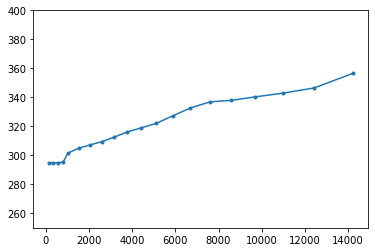

In [174]:
plot(gh.values[:20], theta[:20], marker='.')
ylim([250,400])
#xlim([0,11e3])

In [172]:
stability =np.diff(theta) / np.diff(gh.values)

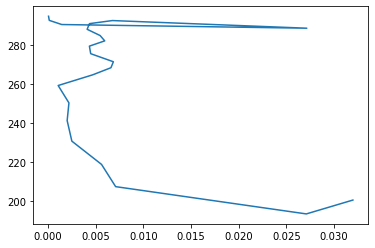

In [178]:
plot(stability[:22], t.values[:22])

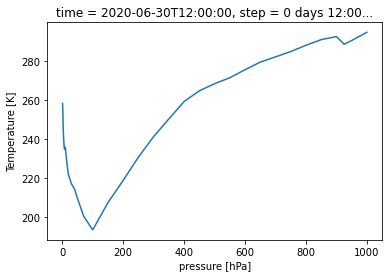

In [140]:
profile.plot()

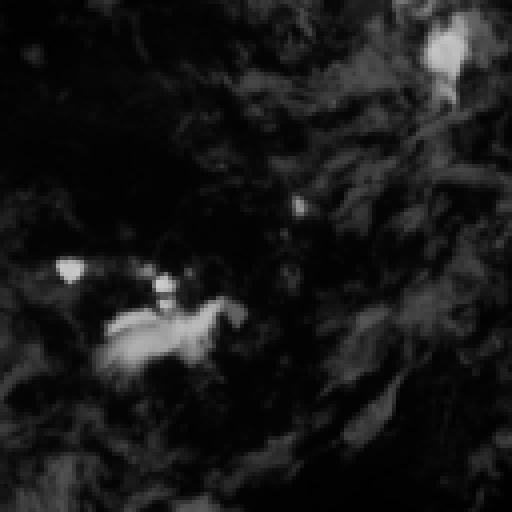

In [46]:
resize(make_image(search[-128:,-128:]))

In [725]:
s = 1
template_size = 8
canvas = np.full((64*s,64*s), np.nan, dtype=np.float64)

np.random.seed(0)
# Fill first 2 lines and first 2 columns of 3rd
seed = tile.ravel()[np.random.randint(0, tile.size-1, canvas.shape[1]*(template_size-1))]
canvas.ravel()[:len(seed)] = seed
seed = tile.ravel()[np.random.randint(0, tile.size-1, canvas.shape[0]*(template_size-1))]
canvas[:,:template_size-1] = seed.reshape((-1,template_size-1))
# canvas[:,:template_size-1] = 295
# canvas[:template_size-1] = 295
canvas[:,:template_size-1] = tile[:,:template_size-1]
canvas[:template_size-1] = tile[:template_size-1]

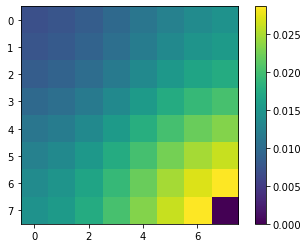

In [728]:
weights = np.zeros((template_size*2+1,template_size*2+1))
weights[template_size,template_size] = 1
weights = scipy.ndimage.filters.gaussian_filter(weights, 5)[:template_size,:template_size]
weights[template_size-1,template_size-1] = 0
weights /= weights.sum()
imshow(weights)
colorbar()

In [729]:
tile_view = np.lib.stride_tricks.sliding_window_view(tile, (template_size,template_size))

In [730]:
topk = 5
with tqdm(range(template_size-1, canvas.shape[0])) as bar:
    for i in bar:
        for j in range(template_size-1, canvas.shape[1]):
            template = canvas[i-template_size+1:i+1,j-template_size+1:j+1]
            sqr_err = ((tile_view - np.nan_to_num(template[np.newaxis,np.newaxis]))**2)
            mean_sqr_err = (sqr_err*weights).sum(axis=(2,3))
            best_i, best_j = np.unravel_index(np.argpartition(mean_sqr_err.ravel(), topk)[:topk], mean_sqr_err.shape)
            #best_i, best_j = np.unravel_index(mean_sqr_err.argmin(), mean_sqr_err.shape)
            choice = np.random.randint(0,topk)
            best_i = best_i[choice]
            best_j = best_j[choice]
            s = tile[best_i:best_i+template_size, best_j:best_j+template_size]
            canvas[i,j] = s[-1,-1]
#             break
#         break

100%|██████████| 57/57 [00:08<00:00,  6.98it/s]


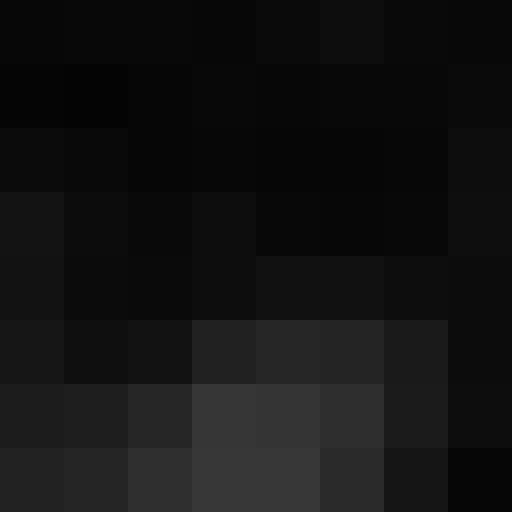

In [731]:
resize(make_image(s))

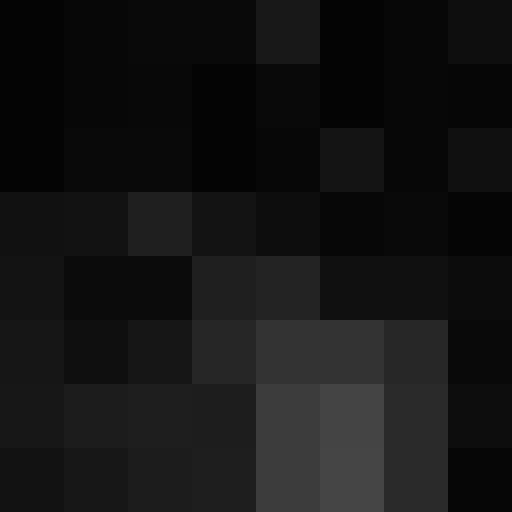

In [732]:
resize(make_image(template))

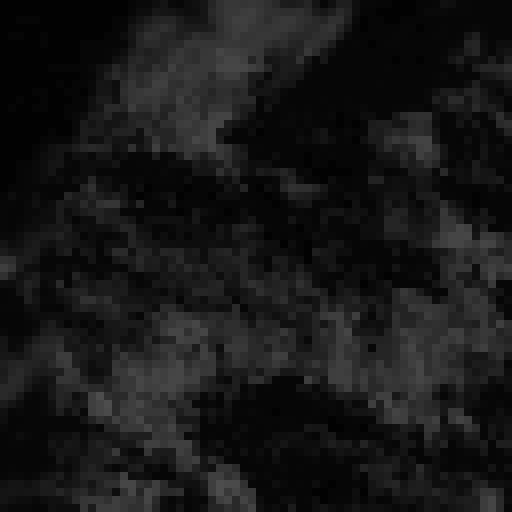

In [733]:
resize(make_image(canvas[:,:]))

In [734]:
tile.shape

(64, 64)

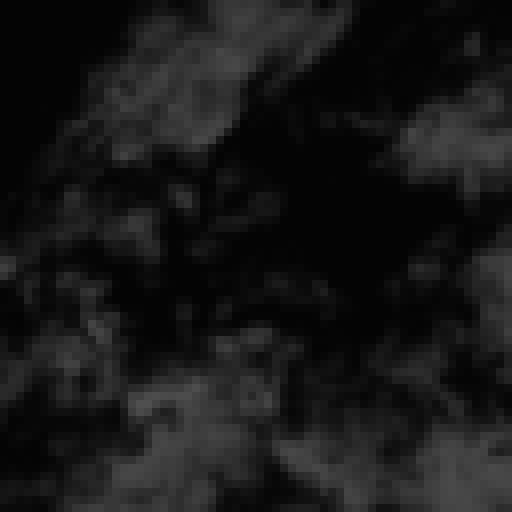

In [735]:
resize(make_image(tile))